In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [13]:
p_nw = []
p_net_nw = []
loss_nw = []
loss_net_nw = []
bool_nw = []

for network_name in ["Random_ER", "Random_SF", "ChIP_hTFtarget", "ChIP_TIP", "ChIP_TIP_K562", "CoExpr_perturb_0.5", "CoExpr_GTEx_WholeBlood_0.75", "CoExpr_ENCODE_K562_0.75", "BIOGRID", "STRING", "Combine", "DAGMA_thresholdAdaptive"]:
    
    # measurements across 10 random sample split
    p_rs = []
    p_net_rs = []
    loss_rs = []
    loss_net_rs = []
    bool_rs = []
    
    for rs in range(10):
        # read data
        X_train = pd.read_csv("../../result/input_perturb_go/%d/X_train_stratified" % rs, sep="\t", index_col=0).values
        X_valid = pd.read_csv("../../result/input_perturb_go/%d/X_valid_stratified" % rs, sep="\t", index_col=0).values
        X_test = pd.read_csv("../../result/input_perturb_go/%d/X_test_stratified" % rs, sep="\t", index_col=0).values
        Y_test = pd.read_csv("../../result/input_perturb_go/%d/Y_test_stratified" % rs, sep="\t", index_col=0).values.reshape(-1)
        Y_test_gene = pd.read_csv("../../result/input_perturb_go/%d/Y_test_stratified" % rs, sep="\t", index_col=0).index

        test_mask = np.concatenate([[False] * len(X_train), [False] * len(X_valid), [True] * len(X_test)])

        # mask of whether a test node is in the DAGMA graph
        dag = pd.read_csv("../../result/network_perturb_go/DAGMA_thresholdAdaptive.tsv", sep="\t", header=None)
        id2genes = pd.read_csv("../../result/network_perturb_go/valid_genes", sep="\t").set_index("ID")['genes'].to_dict()
        dag[0] = dag[0].map(id2genes)
        dag[1] = dag[1].map(id2genes)
        dag_genes = list(set.union(set(dag[0]), set(dag[1])))
        test_inDAG = Y_test_gene.isin(dag_genes)

        # measurements across 10 random init repeats
        p_rep = []
        p_net_rep = []
        loss_rep = []
        loss_net_rep = []

        for rep in range(10):
            prefix = "../../result/model_perturb_go/%s/%d/model%d" % (network_name, rs, rep)
            with open(prefix+".para", "rb") as f:
                best_params, X1, out, loss1, loss2 = pickle.load(f)
            Y_pred = out[test_mask].reshape(-1)

            loss_rep.append(F.mse_loss(torch.tensor(Y_test), torch.tensor(Y_pred)).item())
            loss_net_rep.append(F.mse_loss(torch.tensor(Y_test[test_inDAG]), torch.tensor(Y_pred[test_inDAG])).item())
            p_rep.append(pearsonr(Y_test, Y_pred)[0])
            p_net_rep.append(pearsonr(Y_test[test_inDAG], Y_pred[test_inDAG])[0])
        bool_rep = ~np.isnan(np.array(p_net_rep))

        p_rs.append(p_rep)
        p_net_rs.append(p_net_rep)
        loss_rs.append(loss_rep)
        loss_net_rs.append(loss_net_rep)
        bool_rs.append(bool_rep)
        
    p_nw.append(p_rs)
    p_net_nw.append(p_net_rs)
    loss_nw.append(loss_rs)
    loss_net_nw.append(loss_net_rs)
    bool_nw.append(bool_rs)

/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [15]:
p_nw = np.array(p_nw)
p_net_nw = np.array(p_net_nw)
loss_nw = np.array(loss_nw)
loss_net_nw = np.array(loss_net_nw)
bool_nw = np.array(bool_nw)

### all genes

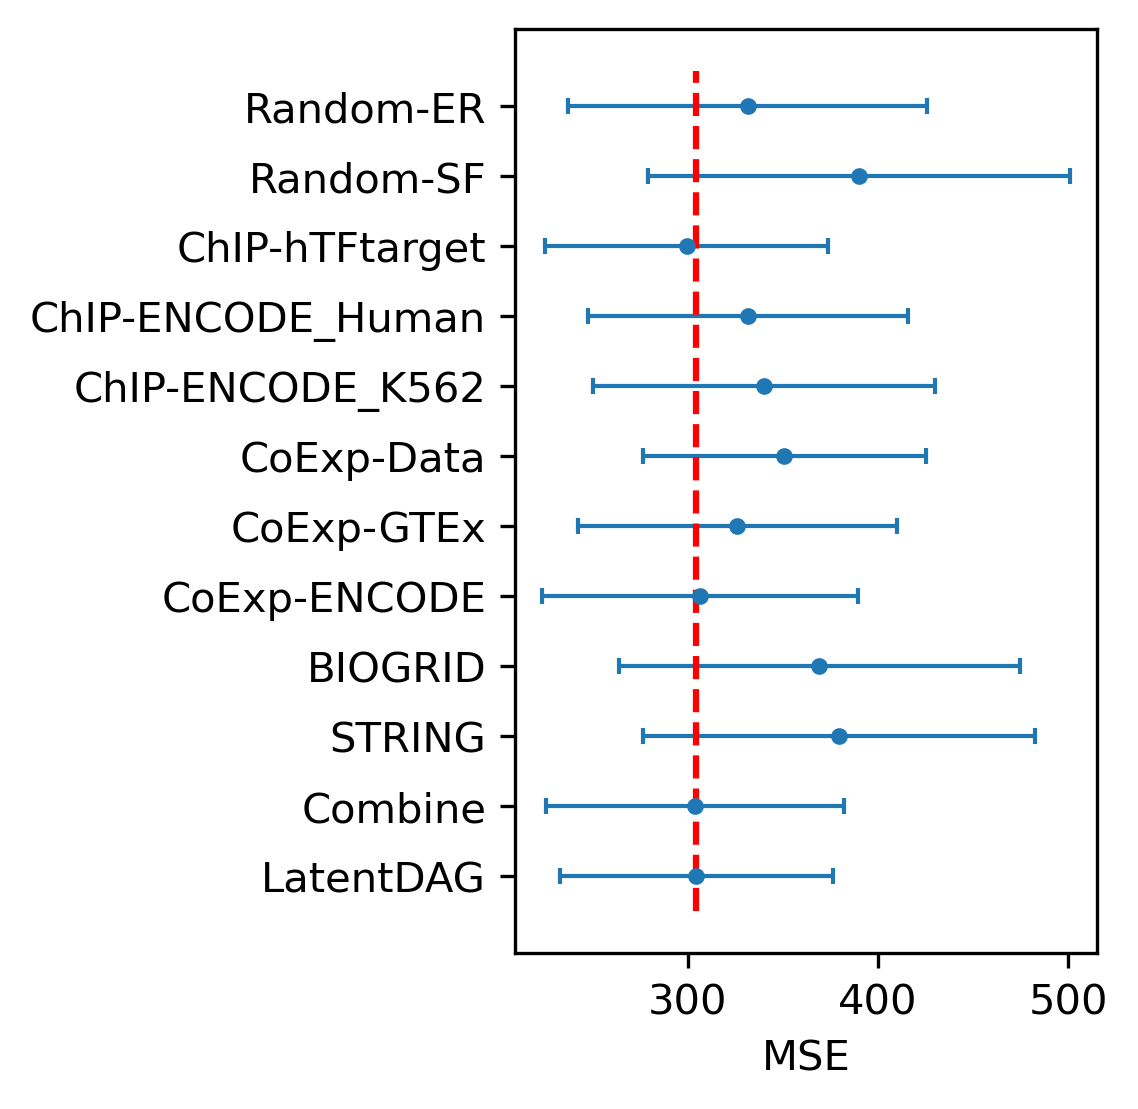

In [16]:
mean_mse = []
std_mse = []
for ii in range(12):
    val = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    mean_mse.append(val.mean())
    std_mse.append(val.std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_K562", "CoExp-Data", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine", "LatentDAG"][::-1])
ax.set_xlabel("MSE")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./figureS1_go_mse.pdf", dpi="figure", bbox_inches="tight")

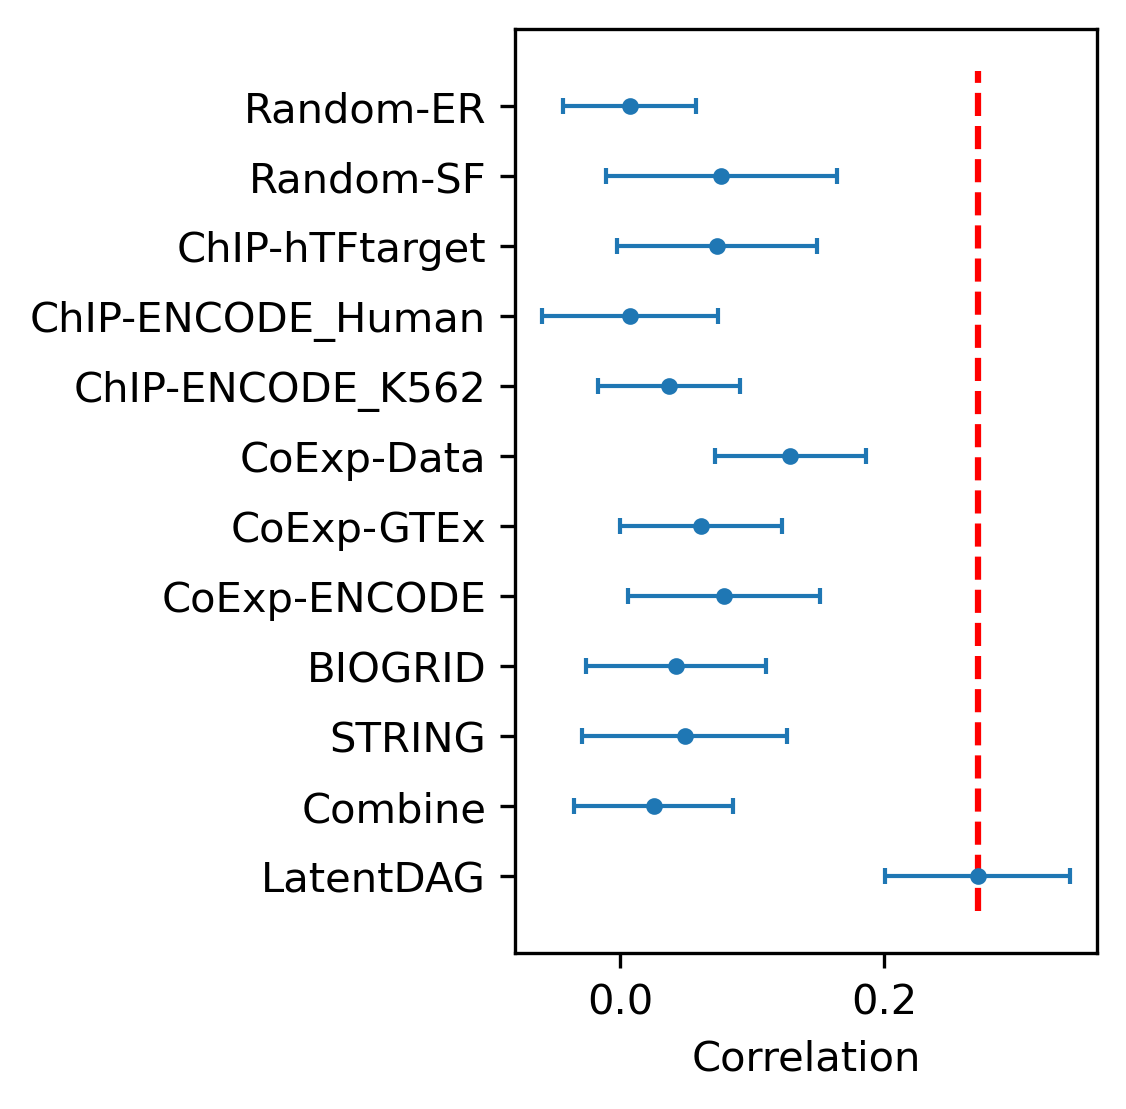

In [17]:
mean_mse = []
std_mse = []
for ii in range(12):
    mean_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].mean())
    std_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_K562", "CoExp-Data", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine", "LatentDAG"][::-1])
ax.set_xlabel("Correlation")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./figureS1_go_p.pdf", dpi="figure", bbox_inches="tight")

### significance

In [18]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind_from_stats

In [19]:
for ii in range(12):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=2.2678555597978316, pvalue=0.024507344419429793)
Ttest_indResult(statistic=6.395785650752183, pvalue=1.5640416165696194e-09)
Ttest_indResult(statistic=-0.48764103234977857, pvalue=0.6263467998153851)
Ttest_indResult(statistic=2.4561589093229275, pvalue=0.014928415538575759)
Ttest_indResult(statistic=3.0858534180466752, pvalue=0.002335544739276988)
Ttest_indResult(statistic=4.453211748372649, pvalue=1.4162864686985121e-05)
Ttest_indResult(statistic=1.9493072533479687, pvalue=0.05270771628356717)
Ttest_indResult(statistic=0.16235392142464272, pvalue=0.8711966310425665)
Ttest_indResult(statistic=5.036423512974575, pvalue=1.1749467140403296e-06)
Ttest_indResult(statistic=5.947103494618311, pvalue=1.425827886130141e-08)
Ttest_indResult(statistic=-0.058753023096951115, pvalue=0.9532087400664344)
Ttest_indResult(statistic=0.0, pvalue=1.0)


In [20]:
for ii in range(12):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-2,:,:].reshape(-1)[bool_nw[-2,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=2.247230427984963, pvalue=0.025776276395564207)
Ttest_indResult(statistic=6.278909002179453, pvalue=2.6313861507295997e-09)
Ttest_indResult(statistic=-0.40981791298243214, pvalue=0.682383647836224)
Ttest_indResult(statistic=2.4217138064231487, pvalue=0.01635329768358738)
Ttest_indResult(statistic=3.0348109251644506, pvalue=0.0027363753234757398)
Ttest_indResult(statistic=4.328321319203839, pvalue=2.386028216153686e-05)
Ttest_indResult(statistic=1.9329772572312633, pvalue=0.05467174775374549)
Ttest_indResult(statistic=0.21117600644903914, pvalue=0.8329678725835663)
Ttest_indResult(statistic=4.945047894337942, pvalue=1.7167559444428687e-06)
Ttest_indResult(statistic=5.826434472544869, pvalue=2.473885686388845e-08)
Ttest_indResult(statistic=0.0, pvalue=1.0)
Ttest_indResult(statistic=0.058753023096951115, pvalue=0.9532087400664344)


###### pearson

In [21]:
for ii in range(12):
    a1 = p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-30.267061395400717, pvalue=4.637587246270538e-72)
Ttest_indResult(statistic=-17.052907622663184, pvalue=8.40401582040896e-40)
Ttest_indResult(statistic=-18.964703597571933, pvalue=3.1004760018703115e-46)
Ttest_indResult(statistic=-26.986924232462002, pvalue=5.416801267271049e-68)
Ttest_indResult(statistic=-26.319428792726185, pvalue=3.301953044409988e-64)
Ttest_indResult(statistic=-15.528480953283797, pvalue=1.357085889667288e-35)
Ttest_indResult(statistic=-22.318221754449308, pvalue=2.1735429387984894e-55)
Ttest_indResult(statistic=-18.910518763212423, pvalue=3.810501927695406e-46)
Ttest_indResult(statistic=-23.25236921673364, pvalue=2.4102661667029135e-58)
Ttest_indResult(statistic=-21.107019024967155, pvalue=2.710914975113752e-52)
Ttest_indResult(statistic=-26.33843607639069, pvalue=1.0933737122620473e-65)
Ttest_indResult(statistic=0.0, pvalue=1.0)
